In [1]:
import pandas as pd
#from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("train.csv")

Data Notes:
You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

Data range: Jan 1, 2011 to Dec 12, 2012

datetime - hourly date + timestamp <br>
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter <br>
holiday - whether the day is considered a holiday<br>
workingday - whether the day is neither a weekend nor holiday<br>
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy <br>
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist <br>
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds <br>
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog <br>
temp - temperature in Celsius<br>
atemp - "feels like" temperature in Celsius<br>
humidity - relative humidity<br>
windspeed - wind speed<br>
casual - number of non-registered user rentals initiated<br>
registered - number of registered user rentals initiated<br>
count - number of total rentals<br>

# Data Preparation

Cleaning up the date format:

In [26]:
data['datetime'] = pd.to_datetime(data.datetime)
data.loc[:, 'date'] = data['datetime'].dt.date
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 13 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
date          10886 non-null object
dtypes: datetime64[ns](1), float64(3), int64(8), object(1)
memory usage: 1.5+ MB


In [4]:
data.index = data.datetime

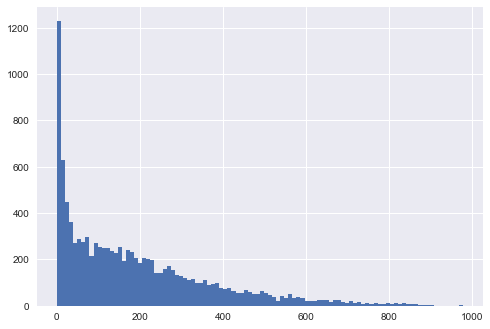

In [5]:
plt.hist(data['count'], bins = 100)
plt.show()

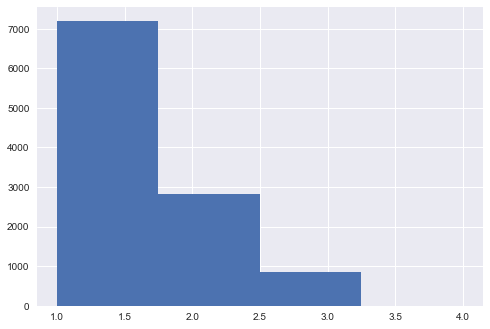

In [6]:
plt.hist(data['weather'], bins = 4)
plt.show()

In [7]:
data.groupby('weather').count()

,datetime,season,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,date
weather,,,,,,,,,,,,
1,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192
2,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834
3,859,859,859,859,859,859,859,859,859,859,859,859
4,1,1,1,1,1,1,1,1,1,1,1,1


In [8]:
data[data['weather'] == 4] #interesting... only one hour from all the data is classified as 4 for the weather

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date
datetime,,,,,,,,,,,,,
2012-01-09 18:00:00,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164,2012-01-09


### Plot year, season and their mean daily maximums rental count

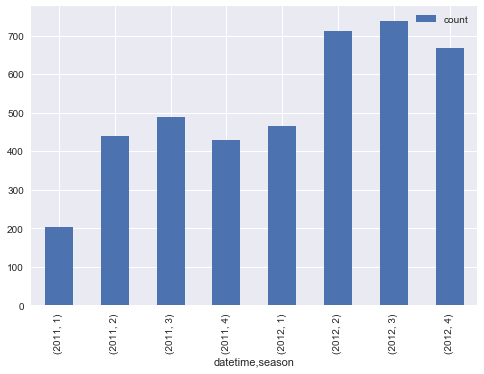

In [9]:
seasonal_avgs = data.groupby([data.date, 
                              data.season, data.datetime.dt.year])['count'].max().groupby(['datetime', 'season']).mean()
seasonal_avgs = pd.DataFrame(seasonal_avgs)

seasonal_avgs.plot(kind = 'bar')
plt.show()

In [10]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01


### Workday vs Holiday vs Weekend Means

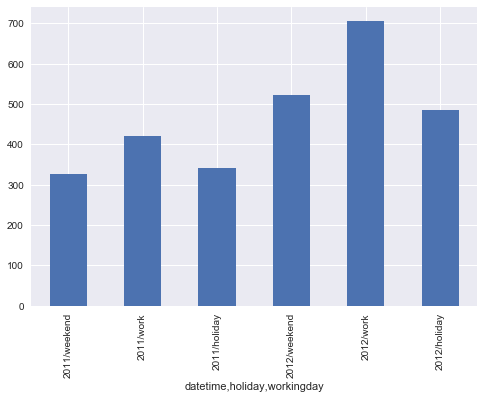

In [11]:
whw = data.groupby(['date', 
                    'holiday', 
                    'workingday', 
                    data.datetime.dt.year])['count'].max().groupby(['datetime',
                                                                    'holiday', 
                                                                    'workingday']).mean()
#
ax = whw.plot(kind = 'bar')
ax.set_xticklabels(['2011/weekend', '2011/work', '2011/holiday', '2012/weekend', '2012/work', '2012/holiday'])
plt.show()

#unneccessary code:
#whw = pd.DataFrame(whw)
#whw.loc[:, 'weekend'] =  np.logical_not(np.logical_or(np.array(whw.index.get_level_values(1)), 
#                                                      np.array(whw.index.get_level_values(2)))).astype(int)
#whw.loc[:, 'hldy'] = np.array(whw.index.get_level_values(1))
#whw.loc[:, 'wrkday'] = np.array(whw.index.get_level_values(2))
#whw.groupby(['hldy', 'wrkday']).mean().plot(kind = 'bar')


### Scatterplot of first year of data

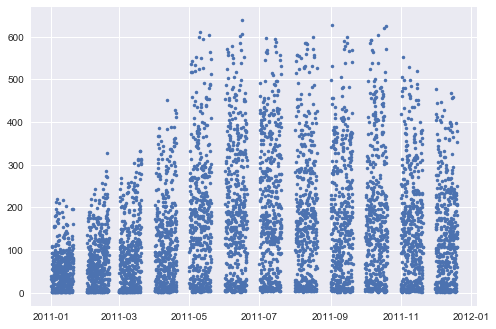

In [12]:
plt.plot(data.loc['1/1/2011':'31/12/2011','count'], '.')
plt.show()

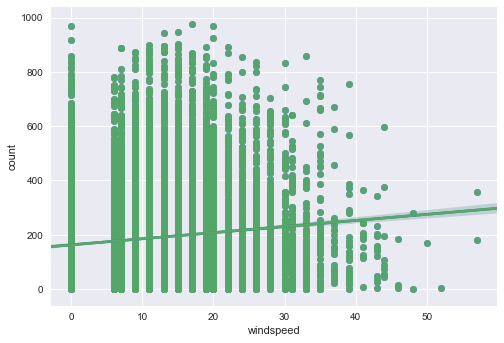

In [25]:
#plot windspeed vs count
sns.regplot(x="windspeed", y="count", data=data)
plt.show()

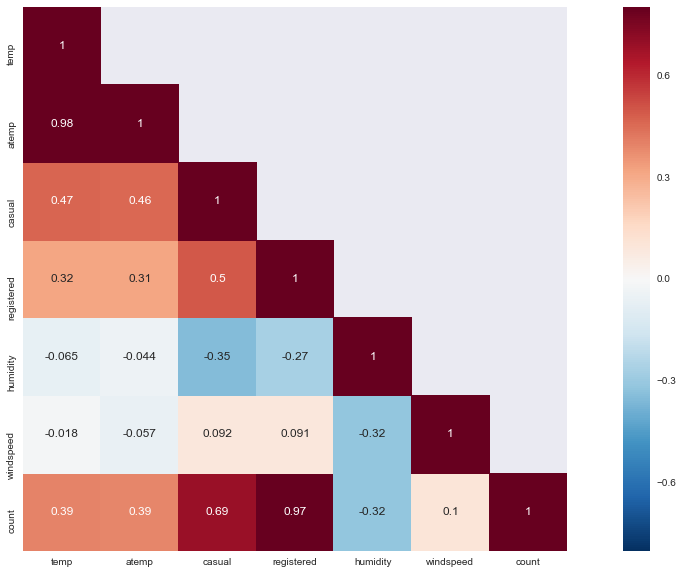

In [39]:
#given so many datapoints (~10^4), p-values for pearson correlation coeff are going to be <<<0.05
corMatt = data[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corMatt, mask=mask,vmax=.8, square=True,annot=True)
plt.show()

In [38]:
#check a few p-values to be sure
out = []
out.append(sp.stats.pearsonr(data['temp'], data.atemp))
out.append(sp.stats.pearsonr(data['windspeed'], data['count']))
out.append(sp.stats.pearsonr(data['humidity'], data['count']))
out

[(0.98494811048170727, 0.0),
 (0.10136947021033278, 2.8984072031669372e-26),
 (-0.31737147887659456, 2.9215416637500742e-253)]

#### Correlation Coefficient Analysis
'atemp' and temp are highly correlated (0.98) hence we will drop atemp from the MLR model
Additionally there are many 0 values for windspeed and this predictor has a low correlation coefficient.

We will drop atemp and windspeed from the MLR model